In [75]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_blobs

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter
import torch.profiler

from GPUtil import showUtilization as gpu_usage

Using torch 1.13.1


In [76]:
class LangevinSampler():
    def __init__(self, p0_sigma, num_z_samples, batch_size, prior_sample_steps, prior_step_size, prior_sigma, posterior_sample_steps, posterior_step_size, posterior_sigma, device):
        
        # Initialize the sampler with the given parameters
        self.p0_sigma = p0_sigma
        self.num_z = num_z_samples
        self.batch_size = batch_size
        self.e_Lsteps = prior_sample_steps
        self.e_step = prior_step_size
        self.e_sigma = prior_sigma
        self.g_Lsteps = posterior_sample_steps
        self.g_step = posterior_step_size
        self.g_sigma = posterior_sigma
        self.device = device
    
    def sample_p0(self):
        
        # Sample from the prior distribution
        return self.p0_sigma * torch.randn(self.batch_size, self.num_z, device=self.device)

    def sample_exp_prior(self, z, EBMmodel):
        
        # Sample from the exponentially-tilted prior distribution
        z = z.clone().detach()
        z.requires_grad = True
        
        for i in range(self.e_Lsteps):
            
            # Compute the gradient of the energy function
            f = EBMmodel(z)
            grad_f = torch.autograd.grad(f.sum(), z)[0]
            
            # Compute the gradient of the log of the prior distribution
            grad_log_f = -0.5 * self.e_step*self.e_step * (grad_f + z / ((self.e_sigma*self.e_sigma)))
            
            # Langevin update
            z = z + grad_log_f + self.e_step * torch.randn_like(z)
        
        # Compute the norm of the gradient of the energy function
        f_grad_norm = grad_f.view(self.batch_size, -1).norm(dim=1).mean()
        
        return z.detach(), f_grad_norm
    
    def sample_posterior(self, z, x, GENmodel, EBMmodel):
        
        # Sample from the posterior distribution
        z = z.clone().detach()
        z.requires_grad = True
        
        for i in range(self.g_Lsteps):
            
            # Compute the gradient of the log of the likelihood function
            x_pred = GENmodel(z)
            log_g = 1.0 / (2.0 * self.g_sigma*self.g_sigma) * torch.mean((x_pred - x) ** 2)/(self.g_sigma*self.g_sigma)
            grad_g = torch.autograd.grad(log_g, z)[0]

            # Compute the gradient of the energy function
            f = EBMmodel(z)
            grad_f = torch.autograd.grad(f.sum(), z)[0]
            
            # Compute the gradient of the log of the posterior distribution
            grad_log_likelihood = -0.5 * self.g_step*self.g_step * (grad_g + grad_f + z / (self.e_sigma*self.e_sigma))
            
            # Langevin update
            z = z + grad_log_likelihood + self.g_step * torch.randn_like(z)

            # Compute the norm of the gradients of the likelihood and energy functions
            g_grad_norm = grad_g.view(self.batch_size, -1).norm(dim=1).mean()
            e_grad_norm = grad_f.view(self.batch_size, -1).norm(dim=1).mean()

        return z.detach(), g_grad_norm, e_grad_norm
            

In [77]:
class priorEBM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),  
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  
                )
            
    def forward(self, z):
        # Returns f_a(z)
        return self.layers(z)
    
class topdownGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  
                )
    
    def forward(self, z):
        # Returns g_b(z)
        return self.layers(z)

In [78]:
def EBM_loss(z_prior, z_posterior, EBMmodel):
    en_pos = torch.mean(EBMmodel(z_posterior.detach()), dim=0)
    en_neg = torch.mean(EBMmodel(z_prior.detach()), dim=0)
            
    return (en_pos - en_neg).mean()
        
lossE = EBM_loss
lossG = nn.MSELoss(reduction='mean')

  0%|          | 0/500 [00:00<?, ?it/s]

STAGE:2023-11-14 16:21:57 372608:372608 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-11-14 16:21:57 372608:372608 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-11-14 16:22:02 372608:372608 output_json.cpp:417] Completed Stage: Post Processing


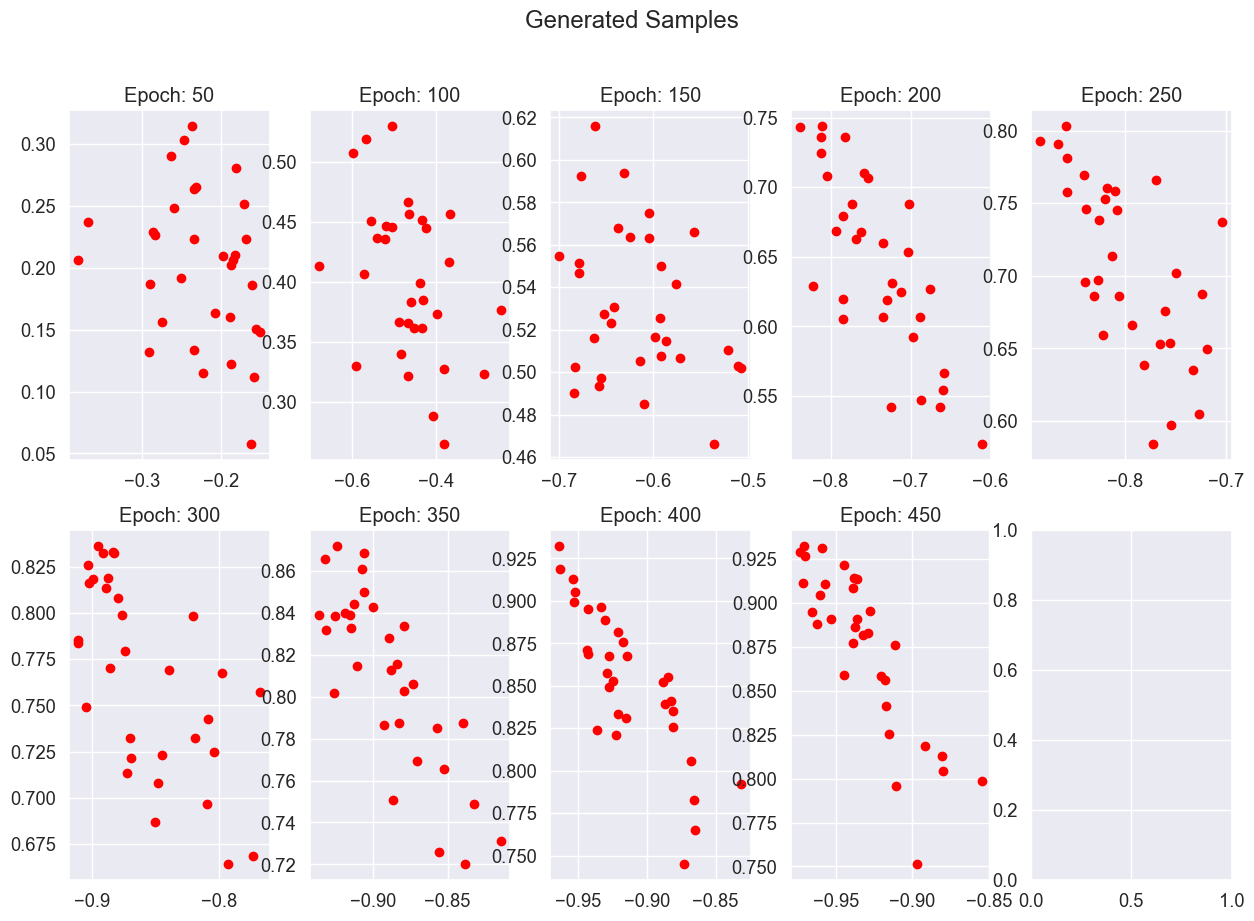

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
NUM_EPOCHS = 500#6000
BATCH_SIZE = 32
DATA_SAMPLES = 5000

Z_SAMPLES = 100

E_LR = 0.000002
G_LR = 0.00001

E_STEP = 0.4
G_STEP = 0.1

E_SAMPLE_STEPS = 25
G_SAMPLE_STEPS = 25

p0_SIGMA = 1
EXP_PRIOR_SIGMA = 1
GENERATOR_SIGMA = 1

Sampler = LangevinSampler(
    p0_sigma=p0_SIGMA,
    num_z_samples=Z_SAMPLES,
    batch_size=BATCH_SIZE,
    prior_sample_steps=E_SAMPLE_STEPS,
    prior_step_size=E_STEP,
    prior_sigma=EXP_PRIOR_SIGMA,
    posterior_sample_steps=G_SAMPLE_STEPS,
    posterior_step_size=G_STEP,
    posterior_sigma=GENERATOR_SIGMA,
    device=device
)

# Load the moons dataset
X, _ = make_blobs(n_samples=DATA_SAMPLES, n_features=2, random_state=42)
X = torch.tensor(X).float().to(device)
loader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

# Create the model and optimizer
EBMmodel = priorEBM(Z_SAMPLES, Z_SAMPLES).to(device)
GENmodel= topdownGenerator(Z_SAMPLES, X.shape[1]).to(device)

EBMoptimiser = torch.optim.Adam(EBMmodel.parameters(), lr=E_LR)
GENoptimiser = torch.optim.Adam(GENmodel.parameters(), lr=G_LR)

# Write to tensorboard 10 times
sample_every = NUM_EPOCHS//10
writer = SummaryWriter(f"runs/VanillaEBM")
num_plots = (NUM_EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(NUM_EPOCHS))

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs/VanillaEBM/profilerlogs'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for epoch in tqdm_bar:
        total_loss = 0
        for batch_idx, x in enumerate(loader): 
            batch_size = x.shape[0]
            
            # 1a. Sample from latent prior p0(z)
            z0_EBM = Sampler.sample_p0() 
            z0_GEN = Sampler.sample_p0()
            
            zK_EBM, grad_norm = Sampler.sample_exp_prior(z0_EBM, EBMmodel) # p(z|M)
            zK_GEN, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z0_GEN, x, GENmodel, EBMmodel) # p(z|x, M)

            # # 1b. Expontentially tilt z, sample from posterior
            # z_prior, grad_norm = Sampler.sample_exp_prior(z0_noise, EBMmodel) # p(z|M)
            # z_posterior, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z_prior, x, GENmodel, EBMmodel) # p(z|x, M)
            
            # 2. Train generator
            GENoptimiser.zero_grad()
            x_pred = GENmodel(zK_GEN.detach()) + GENERATOR_SIGMA * torch.randn_like(x)
            loss_gen = lossG(x_pred, x)
            loss_gen.backward()
            GENoptimiser.step()
            
            # 3. Train EBM
            EBMoptimiser.zero_grad()
            loss_ebm = lossE(zK_EBM, zK_GEN, EBMmodel)
            loss_ebm.backward()
            EBMoptimiser.step()
            
            total_loss += loss_ebm.item()  + loss_gen.item()
            
            prof.step()
            if batch_idx >= 1 + 1 + 3:
                break

        tqdm_bar.set_description(f"Epoch {epoch}: Loss: {total_loss / (BATCH_SIZE):.4f}")

        if (epoch % sample_every == 0 or epoch == NUM_EPOCHS) and (epoch > 0):
            
            # Need gradients for langevin sampling
            z0_GEN = Sampler.sample_p0()
            #zK_GEN, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z0_GEN, x, GENmodel, EBMmodel) # p(z|x, M)

            # Plot a batch of generated samples
            with torch.no_grad():
            
                # Generate 5 samples for each z, i.e. generate 5x as many samples as there are z

                x_pred = GENmodel(zK_GEN) # Get batch of generated samples
                samples = x_pred.detach().cpu() # Average the samples (Monte Carlo estimate)

                plot_num = (epoch // sample_every) - 1
                row = plot_num // num_cols
                col = (plot_num % num_cols)
                axs[row, col].clear()
                axs[row, col].scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
                axs[row, col].set_title(f'Epoch: {epoch}')

                # Convert the Matplotlib figure to a NumPy array
                fig.canvas.draw()
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                # Write the image to TensorBoard
                writer.add_image("VanillaEBM -- Make Moons", image, global_step=epoch, dataformats='HWC')
                Sampler.batch_size = BATCH_SIZE


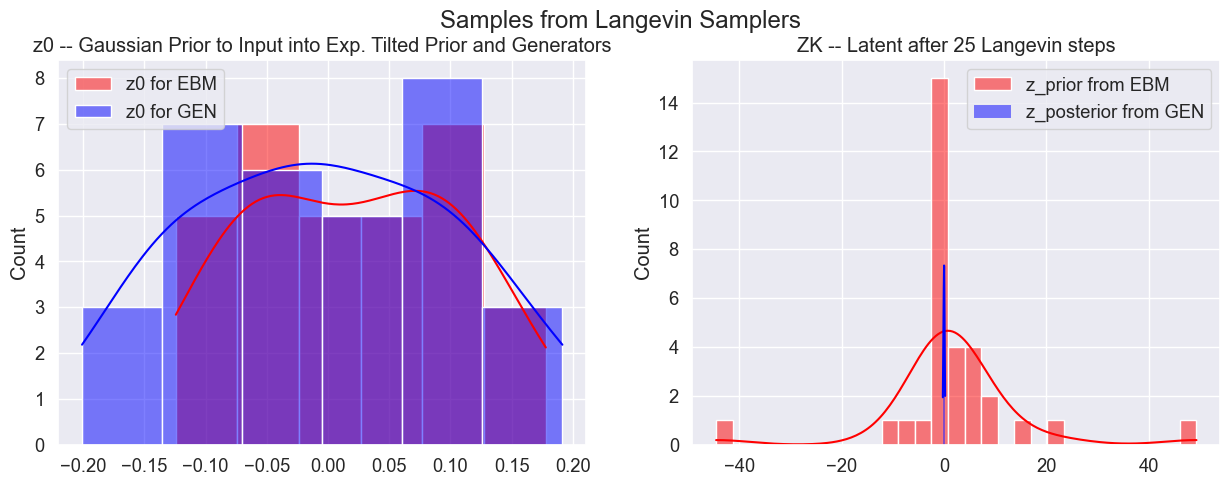

In [ ]:
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Samples from Langevin Samplers")

# Sample from the prior distribution and plot the results
z0_EBM = Sampler.sample_p0() 
z0_GEN = Sampler.sample_p0()

# Mean along the final dimension
z0_EBM_mean = torch.mean(z0_EBM, dim=-1)
z0_GEN_mean = torch.mean(z0_GEN, dim=-1)

# Plot the histograms
sns.histplot(z0_EBM_mean.detach().cpu().numpy(), ax=axs[0], color='red', kde=True, label='z0 for EBM')
sns.histplot(z0_GEN_mean.detach().cpu().numpy(), ax=axs[0], color='blue', kde=True, label='z0 for GEN')
axs[0].set_title(f'z0 -- Gaussian Prior to Input into Exp. Tilted Prior and Generators')
axs[0].legend()

# Sample from the posterior distribution and plot the results
zK_EBM, grad_norm = Sampler.sample_exp_prior(z0_EBM, EBMmodel) # p(z|M)
zK_GEN, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z0_GEN, x, GENmodel, EBMmodel) # p(z|x, M)

# Mean along the final dimension
zK_EBM_mean = torch.mean(zK_EBM, dim=-1)
zK_GEN_mean = torch.mean(zK_GEN, dim=-1)

# Plot the histograms
sns.histplot(zK_EBM_mean.detach().cpu().numpy(), ax=axs[1], color='red', kde=True, label='z_prior from EBM')
sns.histplot(zK_GEN_mean.detach().cpu().numpy(), ax=axs[1], color='blue', kde=True, label='z_posterior from GEN')
axs[1].set_title(f'zK -- Latent after {E_SAMPLE_STEPS} Langevin steps')
axs[1].legend()


RuntimeError: The size of tensor a (32) must match the size of tensor b (5000) at non-singleton dimension 0

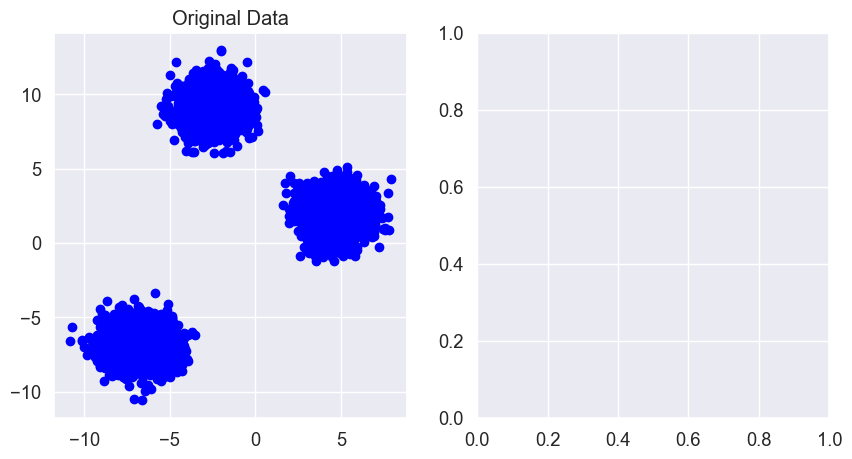

In [ ]:
import numpy as np
import torch.distributions as dist

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original data
axs[0].plot(X[:, 0].cpu(), X[:, 1].cpu(), 'o', color='blue', label='Data')
axs[0].set_title('Original Data')

# Stack the marginals together
num_samples = x.shape[0] * 5
samples_tensor = torch.empty((num_samples, X.shape[1]), dtype=X.dtype, device=X.device)
for i in range(5):
    # Generate 500 sets of posterior samples
    samples = torch.zeros_like(X)
    for j in range(100):
        z0_GEN = Sampler.sample_p0()
        zK_GEN, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z0_GEN, X, GENmodel, EBMmodel) # p(z|x, M)

        normal_dist = dist.Normal(GENmodel(zK_GEN), GENERATOR_SIGMA)
        posterior_samples = normal_dist.sample()
        samples += posterior_samples

    # Take the mean of the posterior samples
    samples /= 100 # Marginalised across z to get p(x)
    samples_tensor[i*X.shape[0]:(i+1)*X.shape[0]] = samples

# Create a 2D histogram of the samples
hist, xedges, yedges = np.histogram2d(samples_tensor[:, 0].cpu(), samples_tensor[:, 1].cpu(), bins=50)

# Plot the histogram as a heatmap
axs[1].imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
axs[1].set_title('p(x)')

plt.show()

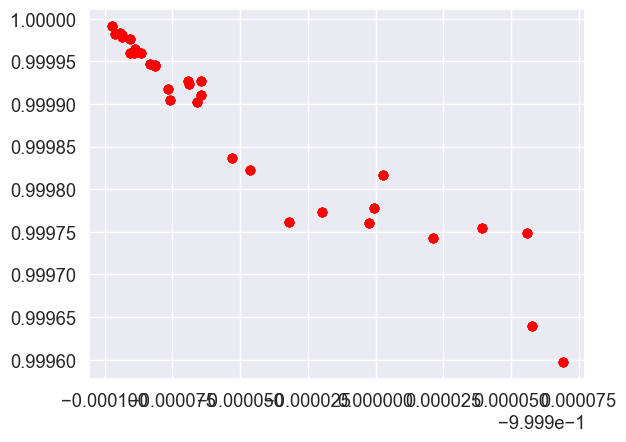

In [ ]:
samples = []

# Generate 5 samples for each z, i.e. generate 5x as many samples as there are z
for _ in range(5):
    x_pred = GENmodel(z_posterior)
    samples.extend(x_pred.detach().cpu())

samples = torch.stack(samples)

plt.scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
plt.show()